In [1]:
## loading package 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import pylab
import seaborn as sns 
from sklearn.metrics.pairwise import cosine_similarity
from statannot import add_stat_annotation
import matplotlib as mpl
from scipy import stats, cluster
import glob
import re
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.stats import multitest
from matplotlib.gridspec import GridSpec

from matplotlib_venn import venn2, venn3
from matplotlib import pyplot as plt

import time

import warnings 
warnings.simplefilter('ignore')

## load_large_dataFrame
def load_large_dataFrame(input_file, sep=",", header=0, index_col=0, chunksize=100000, compressed=False):
    if compressed:
        TextFileReader = pd.read_csv(input_file, chunksize=chunksize, sep=sep, header=header,index_col=index_col, compression='gzip')
    else:
        TextFileReader = pd.read_csv(input_file, chunksize=chunksize, sep=sep, header=header,index_col=index_col)
    dfList=[]
    for df in TextFileReader:
        dfList.append(df)
    final_df = pd.concat(dfList,sort=False)
    return final_df

## 0. Functions

In [2]:
## calculate reactivity from mutant rate matrix
###    1) NAI-N3 - AVG(DMSO)
def calculate_reactivity_from_mutrate(mutrate_df):
    mutrate_df_dmso = mutrate_df.xs("dmso", level="agent", axis=1).mean(axis=1).to_frame('dmso.reac.mean')
    mutrate_df_nai = mutrate_df.xs("nai-n3", level="agent", axis=1)
    ## substract to dmso mean reac 
    dmso_matrix = pd.concat([mutrate_df_dmso]*mutrate_df_nai.columns.size, axis=1)
    dmso_matrix.columns = mutrate_df_nai.columns
    crude_reac = mutrate_df_nai - dmso_matrix
    crude_reac.sort_index(inplace=True)
    return crude_reac
def iterate_batch_stages_for_reactivity_from_mutrate_matrix(mutrate_df):
    #print (mutrate_df)
    concat_list = []
    for [batch, stage, lib_type], stage_mutrate_df in mutrate_df.groupby(['batch','stage','lib_type'], axis=1):
        stage_crude_reac = calculate_reactivity_from_mutrate(stage_mutrate_df)
        concat_list.append(stage_crude_reac)
    crude_reac = pd.concat(concat_list, axis=1)
    return crude_reac

def calculate_reactivity_from_mutrate_subtract_to_same_DMSO(mutrate_df, dmso_lib_type="single"):
    mutrate_df_dmso = mutrate_df.xs("dmso", level="agent", axis=1)
    mutrate_df_dmso = mutrate_df_dmso.xs(dmso_lib_type, level="lib_type", axis=1).mean(axis=1).to_frame('dmso.reac.mean')
    mutrate_df_nai = mutrate_df.xs("nai-n3", level="agent", axis=1)
    ## substract to dmso mean reac 
    dmso_matrix = pd.concat([mutrate_df_dmso]*mutrate_df_nai.columns.size, axis=1)
    dmso_matrix.columns = mutrate_df_nai.columns
    crude_reac = mutrate_df_nai - dmso_matrix
    crude_reac.sort_index(inplace=True)
    return crude_reac

In [3]:
def gene_normalization_1nt(crude_reac, bottom_winsorize=0.0, top_winsorize=0.0, transcriptome_winsorize=False, gene_winsorize=False):
    
    ## transcriptome-wide winsorization
    crude_reac_array = crude_reac.to_numpy()
    if transcriptome_winsorize:
        crude_reac_array = winsorize(crude_reac_array, limits=[bottom_winsorize, top_winsorize], axis=0, nan_policy="omit")
    winsorized_reac = pd.DataFrame(crude_reac_array, index=crude_reac.index, columns=crude_reac.columns)
    
    concat_genes = []
    for gene, gene_crude_reac in winsorized_reac.groupby(level="gene"):
        ## gene winsorization
        crude_reac_array = gene_crude_reac.to_numpy()
        if gene_winsorize:
            crude_reac_array = winsorize(crude_reac_array, limits=[bottom_winsorize, top_winsorize], axis=0, nan_policy="omit")
        gene_winsorized_reac = pd.DataFrame(crude_reac_array, index=gene_crude_reac.index, columns=gene_crude_reac.columns)
   
        concat_stages = []
        for stage, stage_crude_reac in gene_winsorized_reac.items():
            
            
            iqr = stats.iqr(stage_crude_reac)
            if stage_crude_reac.index.size >= 500:
                pct95_val = np.nanpercentile(stage_crude_reac, 99)
            else:
                pct95_val = np.nanpercentile(stage_crude_reac, 95)
            filter_outlies_series = stage_crude_reac.loc[stage_crude_reac < max(pct95_val, 1.5*iqr)]
            pct90_val_filtered = np.nanpercentile(filter_outlies_series, 90)
            avg_pct90_filtered_vals = filter_outlies_series.loc[filter_outlies_series>pct90_val_filtered].mean()
            normalized_reac = stage_crude_reac/avg_pct90_filtered_vals
            concat_stages.append(normalized_reac)
        gene_norm_reac = pd.concat(concat_stages, axis=1)
        concat_genes.append(gene_norm_reac)
    gene_norm_reac = pd.concat(concat_genes, axis=0)
    gene_norm_reac.columns.names = crude_reac.columns.names
    return gene_norm_reac

In [8]:
def remove_first_and_last_100nts_of_each_gene(crude_reac, left_trim=50, right_trim=50):
    concat_lst = []
    for gene, gene_crude_reac in crude_reac.groupby(level="gene"):
       
        gene_len = annot_df.loc[gene, 'full_len']
        if gene_len >= 500:
            gene_crude_reac = gene_crude_reac.loc[gene_crude_reac.index.get_level_values('pos')>=min([50,left_trim])]
            gene_crude_reac = gene_crude_reac.loc[gene_crude_reac.index.get_level_values('pos')<= (gene_len-min([right_trim,50]))]
        else:
            gene_crude_reac = gene_crude_reac.loc[gene_crude_reac.index.get_level_values('pos')>=min([50,left_trim])]
            gene_crude_reac = gene_crude_reac.loc[gene_crude_reac.index.get_level_values('pos')<= (gene_len-min([right_trim,50]))]
        if gene_crude_reac.index.size < 200: 
            continue
        else:
            concat_lst.append(gene_crude_reac)
    out_crude_reac = pd.concat(concat_lst)
    return out_crude_reac

## 1. Generate Reactivity Matrix of Neural Development (time-points)

### 1.1 in 10-nt resolution

In [4]:
## Retrieve mutrate matrix
b1_h9_mutrate = load_large_dataFrame("../Current_Data/01.Mutant_Rate_Matrix.10nt/batch_1.h9.mutrate.10nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_h9_mutrate = load_large_dataFrame("../Current_Data/01.Mutant_Rate_Matrix.10nt/batch_2.h9.mutrate.10nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day0_mutrate = load_large_dataFrame("../Current_Data/01.Mutant_Rate_Matrix.10nt/batch_1.day0.mutrate.10nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day0_mutrate = load_large_dataFrame("../Current_Data/01.Mutant_Rate_Matrix.10nt/batch_2.day0.mutrate.10nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day1_mutrate = load_large_dataFrame("../Current_Data/01.Mutant_Rate_Matrix.10nt/batch_1.day1.mutrate.10nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day1_mutrate = load_large_dataFrame("../Current_Data/01.Mutant_Rate_Matrix.10nt/batch_2.day1.mutrate.10nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day7_mutrate = load_large_dataFrame("../Current_Data/01.Mutant_Rate_Matrix.10nt/batch_1.day7.mutrate.10nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day7_mutrate = load_large_dataFrame("../Current_Data/01.Mutant_Rate_Matrix.10nt/batch_2.day7.mutrate.10nt.csv", header=[0,1,2,3,4], index_col=[0,1])

#b1_h9_mutrate = b1_h9_mutrate.loc[b1_h9_mutrate.isnull().sum(axis=1) < b1_h9_mutrate.columns.size*0.5]
#b1_day0_mutrate = b1_day0_mutrate.loc[b1_day0_mutrate.isnull().sum(axis=1) < b1_day0_mutrate.columns.size*0.5]
#b1_day1_mutrate = b1_day1_mutrate.loc[b1_day1_mutrate.isnull().sum(axis=1) < b1_day1_mutrate.columns.size*0.5]
#b1_day7_mutrate = b1_day7_mutrate.loc[b1_day7_mutrate.isnull().sum(axis=1) < b1_day7_mutrate.columns.size*0.5]
#b2_h9_mutrate = b2_h9_mutrate.loc[b2_h9_mutrate.isnull().sum(axis=1) < b2_h9_mutrate.columns.size*0.5]
#b2_day0_mutrate = b2_day0_mutrate.loc[b2_day0_mutrate.isnull().sum(axis=1) < b2_day0_mutrate.columns.size*0.5]
#b2_day1_mutrate = b2_day1_mutrate.loc[b2_day1_mutrate.isnull().sum(axis=1) < b2_day1_mutrate.columns.size*0.5]
#b2_day7_mutrate = b2_day7_mutrate.loc[b2_day7_mutrate.isnull().sum(axis=1) < b2_day7_mutrate.columns.size*0.5]

h9_mutrate = pd.concat([b1_h9_mutrate, b2_h9_mutrate], axis=1, join="inner")
day0_mutrate = pd.concat([b1_day0_mutrate, b2_day0_mutrate], axis=1, join="inner")
day1_mutrate = pd.concat([b1_day1_mutrate, b2_day1_mutrate], axis=1, join="inner")
day7_mutrate = pd.concat([b1_day7_mutrate, b2_day7_mutrate], axis=1, join="inner")

## human_small_reactivity
rRNA_mutrate = load_large_dataFrame("../Current_Data/01.Mutant_Rate_Matrix.10nt/all_cells.mutrate.rRNA.10nt.csv", header=[0,1,2,3,4], index_col=[0,1])
#rRNA_mutrate = rRNA_mutrate.loc[rRNA_mutrate.index.get_level_values('pos')<1801]
rRNA_mutrate
h9_mutrate = h9_mutrate.loc[~h9_mutrate.index.get_level_values('gene').isin(['human_small','human_large'])]
day0_mutrate = day0_mutrate.loc[~day0_mutrate.index.get_level_values('gene').isin(['human_small','human_large'])]
day1_mutrate = day1_mutrate.loc[~day1_mutrate.index.get_level_values('gene').isin(['human_small','human_large'])]
day7_mutrate = day7_mutrate.loc[~day7_mutrate.index.get_level_values('gene').isin(['human_small','human_large'])]

h9_mutrate = h9_mutrate.loc[~h9_mutrate.index.get_level_values('gene').isin(['human_small'])]
day0_mutrate = day0_mutrate.loc[~day0_mutrate.index.get_level_values('gene').isin(['human_small'])]
day1_mutrate = day1_mutrate.loc[~day1_mutrate.index.get_level_values('gene').isin(['human_small'])]
day7_mutrate = day7_mutrate.loc[~day7_mutrate.index.get_level_values('gene').isin(['human_small'])]

h9_mutrate = pd.concat([h9_mutrate, rRNA_mutrate], axis=0, join="inner")
day0_mutrate = pd.concat([day0_mutrate, rRNA_mutrate], axis=0, join="inner")
day1_mutrate = pd.concat([day1_mutrate, rRNA_mutrate], axis=0, join="inner")
day7_mutrate = pd.concat([day7_mutrate, rRNA_mutrate], axis=0, join="inner")

# h9_crude_reac = calculate_reactivity_from_mutrate(h9_mutrate)
# day0_crude_reac = calculate_reactivity_from_mutrate(day0_mutrate)
# day1_crude_reac = calculate_reactivity_from_mutrate(day1_mutrate)
# day7_crude_reac = calculate_reactivity_from_mutrate(day7_mutrate)

h9_crude_reac = iterate_batch_stages_for_reactivity_from_mutrate_matrix(h9_mutrate)
day0_crude_reac = iterate_batch_stages_for_reactivity_from_mutrate_matrix(day0_mutrate)
day1_crude_reac = iterate_batch_stages_for_reactivity_from_mutrate_matrix(day1_mutrate)
day7_crude_reac = iterate_batch_stages_for_reactivity_from_mutrate_matrix(day7_mutrate)

crude_reac_10nt = pd.concat([h9_crude_reac, day0_crude_reac, day1_crude_reac, day7_crude_reac], axis=1)
crude_reac_10nt

id         RHE1552 RHE1558 RHE1564 RHE1570   RHE1576 RHE1577   RHE1578  \
batch      batch_1 batch_1 batch_1 batch_1   batch_1 batch_1   batch_1   
stage           h9      h9      h9      h9        h9      h9        h9   
lib_type    single  single  single  single    single  single    single   
gene  pos                                                                
A1BG  1260     NaN     NaN     NaN     NaN -0.007508     NaN  0.039362   
      1270     NaN     NaN     NaN     NaN -0.002839     NaN -0.001975   
      1280     NaN     NaN     NaN     NaN -0.001484     NaN  0.005960   
      1290     NaN     NaN     NaN     NaN  0.001304     NaN -0.000229   
      1300     NaN     NaN     NaN     NaN -0.001929     NaN -0.004964   
...            ...     ...     ...     ...       ...     ...       ...   
ZZEF1 6680     NaN     NaN     NaN     NaN       NaN     NaN       NaN   
      6690     NaN     NaN     NaN     NaN       NaN     NaN       NaN   
      6700     NaN     NaN     NaN     NaN       NaN     NaN       NaN   
      6710     NaN     NaN     NaN     NaN       NaN     NaN       NaN   
      6720     NaN     NaN     NaN     NaN       NaN     NaN       NaN   

id           RHE1579 RHE1580 RHE1581  ... RHN1698 RHN1699 RHN1700 RHN1701  \
batch        batch_1 batch_1 batch_1  ... batch_2 batch_2 batch_2 batch_2   
stage             h9      h9      h9  ...    day7    day7    day7    day7   
lib_type      single  single  single  ...  single  single  single  single   
gene  pos                             ...                                   
A1BG  1260  0.106629     NaN     NaN  ...     NaN     NaN     NaN     NaN   
      1270  0.101601     NaN     NaN  ...     NaN     NaN     NaN     NaN   
      1280  0.000419     NaN     NaN  ...     NaN     NaN     NaN     NaN   
      1290  0.012190     NaN     NaN  ...     NaN     NaN     NaN     NaN   
      1300  0.016060     NaN     NaN  ...     NaN     NaN     NaN     NaN   
...              ...     ...     ...  ...     ...     ...     ...     ...   
ZZEF1 6680       NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   
      6690       NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   
      6700       NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   
      6710       NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   
      6720       NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   

id         RHN1702 RHN1703 RHN1704 RHN1705 RHN1706 RHN1707  
batch      batch_2 batch_2 batch_2 batch_2 batch_2 batch_2  
stage         day7    day7    day7    day7    day7    day7  
lib_type    single  single  single  single  single  single  
gene  pos                                                   
A1BG  1260     NaN     NaN     NaN     NaN     NaN     NaN  
      1270     NaN     NaN     NaN     NaN     NaN     NaN  
      1280     NaN     NaN     NaN     NaN     NaN     NaN  
      1290     NaN     NaN     NaN     NaN     NaN     NaN  
      1300     NaN     NaN     NaN     NaN     NaN     NaN  
...            ...     ...     ...     ...     ...     ...  
ZZEF1 6680     NaN     NaN     NaN     NaN     NaN     NaN  
      6690     NaN     NaN     NaN     NaN     NaN     NaN  
      6700     NaN     NaN     NaN     NaN     NaN     NaN  
      6710     NaN     NaN     NaN     NaN     NaN     NaN  
      6720     NaN     NaN     NaN     NaN     NaN     NaN  

[1498068 rows x 280 columns]

In [3]:
#crude_reac_10nt.to_csv("../Current_Data/03.Wide_Reac_Matrix_10nt/neural_differentiate.stages.transcripts.crude_reac.10nt.not_filtered.csv")
#crude_reac_10nt.to_hdf("../Current_Data/03.Wide_Reac_Matrix_10nt/neural_differentiate.stages.transcripts.crude_reac.10nt.not_filtered.h5", key="df")

#crude_reac_10nt.to_hdf("../Current_Data/03.Wide_Reac_Matrix_10nt/neural_differentiate.stages.transcripts.crude_reac.10nt.not_filtered.hd5", key="df")
crude_reac_10nt = pd.read_hdf("../Current_Data/03.Wide_Reac_Matrix_10nt/neural_differentiate.stages.transcripts.crude_reac.10nt.not_filtered.hd5", key="df")

#crude_reac_10nt.to_csv("../Current_Data/03.Wide_Reac_Matrix_10nt/neural_differentiate.stages.transcripts.crude_reac.10nt.not_filtered.csv")

In [5]:
rRNA_mutrate

id                 RHE1534   RHE1540   RHE1546   RHE1552   RHE1554   RHE1558  \
batch              batch_1   batch_1   batch_1   batch_1   batch_1   batch_1   
stage                   h9        h9        h9        h9        h9        h9   
agent                 dmso      dmso      dmso    nai-n3      dmso    nai-n3   
lib_type            single    single    single    single      bulk    single   
gene        pos                                                                
human_small 0     0.060024  0.055250  0.058329  0.058403  0.055565  0.060586   
            10    0.014934  0.015203  0.015731  0.016246  0.014422  0.015303   
            20    0.009641  0.010159  0.010260  0.010349  0.009706  0.009843   
            30    0.011730  0.012597  0.011628  0.011336  0.010627  0.011218   
            40    0.012457  0.012514  0.013167  0.012364  0.011889  0.012405   
...                    ...       ...       ...       ...       ...       ...   
            1830  0.013235  0.021014  0.009622  0.011294  0.009703  0.017524   
            1840  0.014927  0.017200  0.018417  0.011220  0.011282  0.020038   
            1850  0.058704  0.063594  0.041999  0.038866  0.027846  0.044832   
            1860  0.132647  0.121593  0.123970  0.106447  0.169343  0.104906   
            1870       NaN       NaN       NaN  0.849776  0.762441  0.865832   

id                 RHE1560   RHE1564   RHE1566   RHE1570  ...   RHS3591  \
batch              batch_1   batch_1   batch_1   batch_1  ...   batch_2   
stage                   h9        h9        h9        h9  ...        h9   
agent                 dmso    nai-n3    nai-n3    nai-n3  ...    nai-n3   
lib_type              bulk    single      bulk    single  ...    single   
gene        pos                                           ...             
human_small 0     0.056354  0.061506  0.056055  0.057471  ...  0.062540   
            10    0.014909  0.016157  0.014586  0.016479  ...  0.018677   
            20    0.009827  0.010154  0.010203  0.010762  ...  0.013479   
            30    0.011032  0.011674  0.011467  0.012671  ...  0.015475   
            40    0.011991  0.013002  0.012069  0.013211  ...  0.016089   
...                    ...       ...       ...       ...  ...       ...   
            1830  0.009464  0.013314  0.019375  0.019849  ...  0.015628   
            1840  0.011951  0.028561  0.014647  0.008599  ...  0.021757   
            1850  0.029285  0.042037  0.041570  0.057751  ...  0.049910   
            1860  0.170784  0.106361  0.149783  0.107209  ...  0.119386   
            1870  0.751264  0.772959  0.747002  0.868830  ...  0.858751   

id                 RHS3592   RHS3593   RHS3594   RHS3595   RHS3596   RHS3597  \
batch              batch_2   batch_2   batch_2   batch_2   batch_2   batch_2   
stage                   h9        h9        h9        h9        h9        h9   
agent               nai-n3    nai-n3    nai-n3    nai-n3    nai-n3      dmso   
lib_type            single    single    single    single    single    single   
gene        pos                                                                
human_small 0     0.064772  0.063844  0.065084  0.068748  0.061863  0.060891   
            10    0.019772  0.018989  0.020662  0.022681  0.021220  0.016827   
            20    0.014148  0.015020  0.015363  0.016615  0.014075  0.011455   
            30    0.017874  0.017964  0.021630  0.021604  0.015668  0.013434   
            40    0.018803  0.018589  0.020553  0.022321  0.017900  0.014668   
...                    ...       ...       ...       ...       ...       ...   
            1830  0.025905  0.018014  0.019264  0.023247  0.015801  0.014487   
            1840  0.019745  0.025496  0.019298  0.030480  0.021723  0.016867   
            1850  0.054467  0.055271  0.042010  0.049029  0.055597  0.039532   
            1860  0.130180  0.114200  0.125049  0.134603  0.114284  0.142488   
            1870  0.770455  0.813093       NaN       NaN  0.864968       NaN   

id

### 1.2 in 1-nt resolution

In [12]:
## Retrieve mutrate matrix
b1_h9_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.h9.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_h9_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.h9.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day0_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day0.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day0_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day0.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day1_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day1.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day1_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day1.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day7_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day7.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day7_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day7.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])

b1_h9_mutrate = b1_h9_mutrate.loc[b1_h9_mutrate.isnull().sum(axis=1) < b1_h9_mutrate.columns.size*0.5]
b1_day0_mutrate = b1_day0_mutrate.loc[b1_day0_mutrate.isnull().sum(axis=1) < b1_day0_mutrate.columns.size*0.5]
b1_day1_mutrate = b1_day1_mutrate.loc[b1_day1_mutrate.isnull().sum(axis=1) < b1_day1_mutrate.columns.size*0.5]
b1_day7_mutrate = b1_day7_mutrate.loc[b1_day7_mutrate.isnull().sum(axis=1) < b1_day7_mutrate.columns.size*0.5]
b2_h9_mutrate = b2_h9_mutrate.loc[b2_h9_mutrate.isnull().sum(axis=1) < b2_h9_mutrate.columns.size*0.5]
b2_day0_mutrate = b2_day0_mutrate.loc[b2_day0_mutrate.isnull().sum(axis=1) < b2_day0_mutrate.columns.size*0.5]
b2_day1_mutrate = b2_day1_mutrate.loc[b2_day1_mutrate.isnull().sum(axis=1) < b2_day1_mutrate.columns.size*0.5]
b2_day7_mutrate = b2_day7_mutrate.loc[b2_day7_mutrate.isnull().sum(axis=1) < b2_day7_mutrate.columns.size*0.5]

h9_mutrate = pd.concat([b1_h9_mutrate, b2_h9_mutrate], axis=1, join="inner")
day0_mutrate = pd.concat([b1_day0_mutrate, b2_day0_mutrate], axis=1, join="inner")
day1_mutrate = pd.concat([b1_day1_mutrate, b2_day1_mutrate], axis=1, join="inner")
day7_mutrate = pd.concat([b1_day7_mutrate, b2_day7_mutrate], axis=1, join="inner")

## human_small_reactivity
rRNA_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/all_cells.mutrate.rRNA.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
rRNA_mutrate = rRNA_mutrate.loc[rRNA_mutrate.index.get_level_values('pos')<1801]
rRNA_mutrate
h9_mutrate = h9_mutrate.loc[~h9_mutrate.index.get_level_values('gene').isin(['human_small','human_large'])]
day0_mutrate = day0_mutrate.loc[~day0_mutrate.index.get_level_values('gene').isin(['human_small','human_large'])]
day1_mutrate = day1_mutrate.loc[~day1_mutrate.index.get_level_values('gene').isin(['human_small','human_large'])]
day7_mutrate = day7_mutrate.loc[~day7_mutrate.index.get_level_values('gene').isin(['human_small','human_large'])]
h9_mutrate = pd.concat([h9_mutrate, rRNA_mutrate], axis=0, join="inner")
day0_mutrate = pd.concat([day0_mutrate, rRNA_mutrate], axis=0, join="inner")
day1_mutrate = pd.concat([day1_mutrate, rRNA_mutrate], axis=0, join="inner")
day7_mutrate = pd.concat([day7_mutrate, rRNA_mutrate], axis=0, join="inner")

#h9_crude_reac = calculate_reactivity_from_mutrate(h9_mutrate)
#day0_crude_reac = calculate_reactivity_from_mutrate(day0_mutrate)
#day1_crude_reac = calculate_reactivity_from_mutrate(day1_mutrate)
#day7_crude_reac = calculate_reactivity_from_mutrate(day7_mutrate)

h9_crude_reac = iterate_batch_stages_for_reactivity_from_mutrate_matrix(h9_mutrate)
day0_crude_reac = iterate_batch_stages_for_reactivity_from_mutrate_matrix(day0_mutrate)
day1_crude_reac = iterate_batch_stages_for_reactivity_from_mutrate_matrix(day1_mutrate)
day7_crude_reac = iterate_batch_stages_for_reactivity_from_mutrate_matrix(day7_mutrate)

crude_reac_1nt = pd.concat([h9_crude_reac, day0_crude_reac, day1_crude_reac, day7_crude_reac], axis=1)
crude_reac_1nt

id            RHE1552   RHE1558   RHE1564   RHE1570 RHE1576 RHE1577 RHE1578  \
batch         batch_1   batch_1   batch_1   batch_1 batch_1 batch_1 batch_1   
stage              h9        h9        h9        h9      h9      h9      h9   
lib_type       single    single    single    single  single  single  single   
gene   pos                                                                    
AARS1  3160 -0.014062 -0.013265 -0.007111 -0.011765     NaN     NaN     NaN   
       3161  0.006219  0.009141 -0.005271  0.001408     NaN     NaN     NaN   
       3162 -0.015188 -0.014092 -0.010914 -0.008343     NaN     NaN     NaN   
       3163 -0.001078 -0.003511  0.003327  0.004039     NaN     NaN     NaN   
       3164 -0.001998 -0.007063 -0.006680 -0.008562     NaN     NaN     NaN   
...               ...       ...       ...       ...     ...     ...     ...   
TUBA1A 1004       NaN       NaN       NaN       NaN     NaN     NaN     NaN   
       1005       NaN       NaN       NaN       NaN     NaN     NaN     NaN   
       1006       NaN       NaN       NaN       NaN     NaN     NaN     NaN   
       1664       NaN       NaN       NaN       NaN     NaN     NaN     NaN   
       1665       NaN       NaN       NaN       NaN     NaN     NaN     NaN   

id          RHE1579   RHE1580 RHE1581  ...   RHN1698   RHN1699   RHN1700  \
batch       batch_1   batch_1 batch_1  ...   batch_2   batch_2   batch_2   
stage            h9        h9      h9  ...      day7      day7      day7   
lib_type     single    single  single  ...    single    single    single   
gene   pos                             ...                                 
AARS1  3160     NaN -0.007299     NaN  ...       NaN       NaN       NaN   
       3161     NaN  0.000802     NaN  ...       NaN       NaN       NaN   
       3162     NaN  0.007748     NaN  ...       NaN       NaN       NaN   
       3163     NaN  0.001055     NaN  ...       NaN       NaN       NaN   
       3164     NaN  0.002145     NaN  ...       NaN       NaN       NaN   
...             ...       ...     ...  ...       ...       ...       ...   
TUBA1A 1004     NaN       NaN     NaN  ... -0.003994 -0.002022  0.001437   
       1005     NaN       NaN     NaN  ...  0.010023 -0.003912 -0.008846   
       1006     NaN       NaN     NaN  ...  0.007953 -0.000825  0.000976   
       1664     NaN       NaN     NaN  ... -0.124790 -0.083545 -0.169566   
       1665     NaN       NaN     NaN  ... -0.071944  0.224258  0.242512   

id            RHN1701   RHN1702   RHN1703   RHN1704   RHN1705   RHN1706  \
batch         batch_2   batch_2   batch_2   batch_2   batch_2   batch_2   
stage            day7      day7      day7      day7      day7      day7   
lib_type       single    single    single    single    single    single   
gene   pos                                                                
AARS1  3160       NaN       NaN       NaN       NaN       NaN       NaN   
       3161       NaN       NaN       NaN       NaN       NaN       NaN   
       3162       NaN       NaN       NaN       NaN       NaN       NaN   
       3163       NaN       NaN       NaN       NaN       NaN       NaN   
       3164       NaN       NaN       NaN       NaN       NaN       NaN   
...               ...       ...       ...       ...       ...       ...   
TUBA1A 1004 -0.003994  0.002579 -0.002006       NaN       NaN -0.000192   
       1005 -0.004136 -0.005207 -0.011490       NaN       NaN -0.009684   
       1006  0.022309 -0.001975 -0.008300       NaN       NaN -0.000639   
       1664 -0.152325 -0.148733  0.403161  0.570160 -0.010836       NaN   
       1665  0.058121  0.180012  0.079696 -0.089378       NaN       NaN   

id          RHN1707  
batch       batch_2  
stage          day7  
lib_type     single  
gene   pos           
AARS1  3160     NaN  
       3161     NaN  
       3162     NaN  
       3163     NaN  
       3164     NaN  
...             ...  
TUBA1A 1004     NaN  
       1005     NaN  
       1006     NaN  
       16

In [ ]:
crude_reac_1nt.to_csv("../Current_Data/04.Wide_Reac_Matrix_1nt/neural_differentiate.stages.transcripts.crude_reac.csv")`bb

## 2. Generate Reactivity Matrix of Bulk2Single (h9)

### 2.1 in 10-nt resolution

In [4]:
b2s_mutrate = load_large_dataFrame("../Current_Data/01.Mutant_Rate_Matrix.10nt/h9.bulk2single.mutrate.10nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2s_mutrate_rRNA = load_large_dataFrame("../Current_Data/01.Mutant_Rate_Matrix.10nt/h9.bulk2single.mutrate.10nt.rRNA.csv", header=[0,1,2,3,4], index_col=[0,1])
b2s_mutrate = b2s_mutrate.loc[~b2s_mutrate.index.get_level_values('gene').isin(['human_small','human_large'])]
b2s_mutrate = pd.concat([b2s_mutrate, b2s_mutrate_rRNA])
b2s_reac_10nt = iterate_batch_stages_for_reactivity_from_mutrate_matrix(b2s_mutrate)

In [16]:
b2s_reac_10nt.to_csv("../Current_Data/03.Wide_Reac_Matrix_10nt/h9.bulk2single.crude_reac.10nt.csv")

### 2.2 in 1-nt resolution

In [11]:
b2s_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/batch_1.h9.bulk2single.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2s_mutrate_rRNA = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/batch_1.h9.bulk2single.mutrate.1nt.rRNA.csv", header=[0,1,2,3,4], index_col=[0,1])
b2s_mutrate = b2s_mutrate.loc[~b2s_mutrate.index.get_level_values('gene').isin(['human_small','human_large'])]
b2s_mutrate = pd.concat([b2s_mutrate, b2s_mutrate_rRNA])
b2s_reac_1nt = iterate_batch_stages_for_reactivity_from_mutrate_matrix(b2s_mutrate)

In [15]:
#b2s_reac_1nt("../Current_Data/04.Wide_Reac_Matrix_1nt/")

id                 RHE1566   RHE1572   RHE1547   RHE1553   RHE1559   RHE1536  \
batch              batch_1   batch_1   batch_1   batch_1   batch_1   batch_1   
stage                   h9        h9        h9        h9        h9        h9   
lib_type              bulk      bulk   cell_10   cell_10   cell_10  cell_100   
gene        pos                                                                
A1BG        1401 -0.006580  0.005612  0.016736  0.000000  0.028340  0.018519   
            1402  0.002485  0.005481 -0.008772 -0.008772  0.007422  0.013889   
            1403 -0.005680 -0.007657 -0.031317 -0.032620 -0.032102 -0.002282   
            1404 -0.002907  0.002558 -0.008929 -0.008929  0.003267  0.028302   
            1405 -0.002719 -0.005255 -0.013393 -0.017857 -0.005199  0.009390   
...                    ...       ...       ...       ...       ...       ...   
human_small 1866  0.018940  0.016715  0.042478  0.027788  0.012933  0.027479   
            1867 -0.026107 -0.048605  0.020885  0.009286  0.008611 -0.028868   
            1868 -0.138479 -0.128298 -0.130116 -0.162933 -0.121248 -0.091496   
            1869 -0.145812 -0.150118 -0.086813 -0.108139 -0.092817 -0.110977   
            1870 -0.009851  0.012229  0.015145  0.036069  0.042168  0.040634   

id                 RHE1542   RHE1548   RHE1552   RHE1558  ...   RHS3587  \
batch              batch_1   batch_1   batch_1   batch_1  ...   batch_2   
stage                   h9        h9        h9        h9  ...        h9   
lib_type          cell_100  cell_100    single    single  ...    single   
gene        pos                                           ...             
A1BG        1401  0.020725  0.000000       NaN -0.003749  ...       NaN   
            1402  0.000000  0.000000       NaN -0.021418  ...       NaN   
            1403 -0.011628 -0.011628       NaN  0.039267  ...       NaN   
            1404  0.000000  0.000000       NaN  0.009839  ...       NaN   
            1405  0.000000  0.000000       NaN -0.013863  ...       NaN   
...                    ...       ...       ...       ...  ...       ...   
human_small 1866 -0.035833  0.016824 -0.056903  0.003319  ... -0.032054   
            1867 -0.017822 -0.057756 -0.007569 -0.020917  ... -0.036131   
            1868 -0.090938 -0.155158 -0.169498 -0.195771  ... -0.098925   
            1869 -0.073224 -0.163685 -0.111214 -0.180316  ... -0.155233   
            1870  0.025156  0.046464  0.049771  0.065828  ... -0.010541   

id                 RHS3588   RHS3589   RHS3590   RHS3591   RHS3592   RHS3593  \
batch              batch_2   batch_2   batch_2   batch_2   batch_2   batch_2   
stage                   h9        h9        h9        h9        h9        h9   
lib_type            single    single    single    single    single    single   
gene        pos                                                                
A1BG        1401       NaN       NaN       NaN       NaN       NaN       NaN   
            1402       NaN       NaN       NaN       NaN       NaN       NaN   
            1403       NaN       NaN       NaN       NaN       NaN       NaN   
            1404       NaN       NaN       NaN       NaN       NaN       NaN   
            1405       NaN       NaN       NaN       NaN       NaN       NaN   
...                    ...       ...       ...       ...       ...       ...   
human_small 1866  0.056652 -0.018807  0.009929  0.018808  0.046248  0.044301   
            1867 -0.063159 -0.039601 -0.011273 -0.031757 -0.059809 -0.059738   
            1868 -0.272776 -0.106330 -0.080744 -0.220487 -0.161910 -0.236687   
            1869 -0.311065 -0.122306 -0.080131 -0.247398 -0.196140 -0.302448   
            1870  0.051922  0.001201  0.007975  0.085379 -0.002918  0.039721   

id                 RHS3594   RHS3595   RHS3596  
batch              batch_2   batch_2   batch_2  
stage                   h9        h9        h9  
lib_type            single    single    single  
gene        pos                          

## 3. Generate Reactivity Matrix of PUM2 OE/KD 

### 3.1 in 10-nt resolution

In [5]:
pum2_oe_mutrate = load_large_dataFrame("../Current_Data/01.Mutant_Rate_Matrix.10nt/pum2OE.mutrate.10nt.csv", header=[0,1,2,3,4], index_col=[0,1])
pum2_kd_mutrate = load_large_dataFrame("../Current_Data/01.Mutant_Rate_Matrix.10nt/pum2KD.mutrate.10nt.csv", header=[0,1,2,3,4], index_col=[0,1])
#pum2_oe_reac = iterate_batch_stages_for_reactivity_from_mutrate_matrix(pum2_oe_mutrate)
#pum2_kd_reac = iterate_batch_stages_for_reactivity_from_mutrate_matrix(pum2_kd_mutrate)

#pum2_oe_reac

#pum2_oe_reac = load_large_dataFrame("../Current_Data/03.Wide_Reac_Matrix_10nt/pum2OE.transcripts.crude_reac.10nt.csv", header=[0,1,2,3], index_col=[0,1])
#pum2_kd_reac = load_large_dataFrame("../Current_Data/03.Wide_Reac_Matrix_10nt/pum2KD.transcripts.crude_reac.10nt.csv", header=[0,1,2,3], index_col=[0,1])
pum2_kd_mutrate

id                 RHS3465   RHS3466   RHS3467   RHS3468   RHS3469   RHS3470  \
batch                   kd        kd        kd        kd        kd        kd   
stage              control   control   control      pum2      pum2      pum2   
agent               nai-n3    nai-n3    nai-n3    nai-n3    nai-n3    nai-n3   
lib_type            single    single    single    single    single    single   
gene        pos                                                                
A1BG        1260       NaN       NaN       NaN       NaN       NaN       NaN   
            1270       NaN  0.023457       NaN       NaN       NaN       NaN   
            1280       NaN  0.013948       NaN       NaN       NaN       NaN   
            1290       NaN  0.046847       NaN       NaN       NaN       NaN   
            1300       NaN  0.048560       NaN       NaN       NaN       NaN   
...                    ...       ...       ...       ...       ...       ...   
human_small 1820  0.030779  0.027706  0.026320  0.028568  0.025850  0.030067   
            1830  0.027746  0.020982  0.041973  0.028120  0.020943  0.026445   
            1840  0.020218  0.017304  0.023159  0.012965  0.022760  0.032327   
            1850  0.043790  0.049925  0.055896  0.044934  0.043571  0.081245   
            1860  0.145449  0.152179  0.126036  0.139884  0.130095  0.117524   

id                 RHS3471   RHS3472   RHS3473   RHS3474  ...   RHS3503  \
batch                   kd        kd        kd        kd  ...        kd   
stage              control   control   control      pum2  ...   control   
agent               nai-n3    nai-n3    nai-n3    nai-n3  ...      dmso   
lib_type            single    single    single    single  ...    single   
gene        pos                                           ...             
A1BG        1260       NaN       NaN       NaN       NaN  ...       NaN   
            1270       NaN       NaN       NaN       NaN  ...       NaN   
            1280       NaN       NaN       NaN       NaN  ...       NaN   
            1290       NaN       NaN       NaN       NaN  ...       NaN   
            1300       NaN       NaN       NaN       NaN  ...       NaN   
...                    ...       ...       ...       ...  ...       ...   
human_small 1820  0.030225  0.024370  0.029508  0.033091  ...  0.019484   
            1830  0.027897  0.020955  0.022863  0.023834  ...  0.013832   
            1840  0.016156  0.022856  0.031838  0.016237  ...  0.018026   
            1850  0.054519  0.048678  0.046019  0.044112  ...  0.032371   
            1860  0.162764  0.142592  0.135268  0.120311  ...  0.136443   

id                 RHS3504   RHS3505   RHS3506   RHS3507   RHS3508   RHS3509  \
batch                   kd        kd        kd        kd        kd        kd   
stage                 pum2      pum2      pum2   control   control   control   
agent               nai-n3    nai-n3      dmso    nai-n3    nai-n3      dmso   
lib_type            single    single    single    single    single    single   
gene        pos                                                                
A1BG        1260  0.054393       NaN       NaN  0.033566       NaN       NaN   
            1270  0.026549       NaN       NaN  0.045283       NaN       NaN   
            1280  0.025122       NaN       NaN  0.010934       NaN       NaN   
            1290  0.026144       NaN       NaN  0.025244       NaN       NaN   
            1300  0.011411       NaN       NaN  0.021626       NaN       NaN   
...                    ...       ...       ...       ...       ...       ...   
human_small 1820  0.028903  0.021117  0.033349  0.029727  0.045971  0.020326   
            1830  0.028123  0.028499  0.021654  0.028082  0.028387  0.014826   
            1840  0.025790  0.025973  0.021714  0.020159  0.020867  0.015973   
            1850  0.056897  0.068875  0.057030  0.062000  0.071353  0.031172   
            1860  0.118656  0.129448  0.161208  0.140340  0.122905  0.164834   

id

In [8]:
from Rsq_Heterogeneity import heterogeneity_by_rsquare

In [6]:
pum2_oe_mutant = load_large_dataFrame("../Current_Data/01.Mutant_Rate_Matrix.10nt/pum2OE.mutant.10nt.csv", header=[0,1,2,3,4], index_col=[0,1])
pum2_oe_coverage = load_large_dataFrame("../Current_Data/01.Mutant_Rate_Matrix.10nt/pum2OE.coverage.10nt.csv", header=[0,1,2,3,4], index_col=[0,1])

pum2_kd_mutant = load_large_dataFrame("../Current_Data/01.Mutant_Rate_Matrix.10nt/pum2KD.mutant.10nt.csv", header=[0,1,2,3,4], index_col=[0,1])
pum2_kd_coverage = load_large_dataFrame("../Current_Data/01.Mutant_Rate_Matrix.10nt/pum2KD.coverage.10nt.csv", header=[0,1,2,3,4], index_col=[0,1])


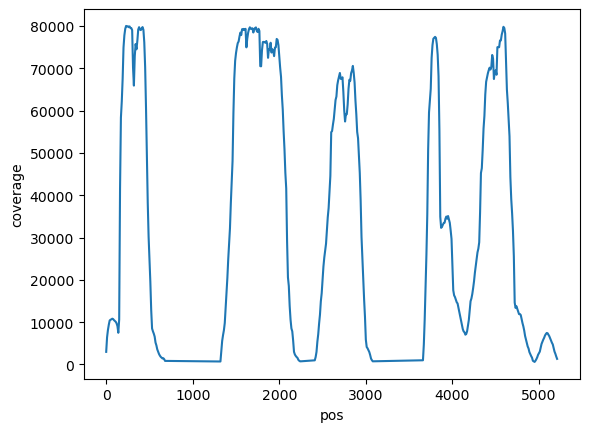

In [14]:
cov_df = pum2_kd_coverage.xs('control', level="stage", axis=1).xs('dmso', level="agent", axis=1).xs('human_large').mean(axis=1).to_frame('coverage').reset_index()
sns.lineplot(data=cov_df, x="pos", y="coverage")
plt.show()

In [16]:
cov_df.to_csv("../../../../../TempFile/JX_barcode/coverage_28S.h9.csv")

In [25]:
concat_lst = []
for stage, subset in pum2_oe_mutant.groupby(level="stage", axis=1):
    subset_mutant = subset
    subset_coverage = pum2_oe_coverage.xs(stage, level="stage", axis=1, drop_level=False)
    subset_rsq = heterogeneity_by_rsquare(subset_mutant, subset_coverage)
    subset_rsq['stage'] = stage
    subset_rsq['rsq'] = np.power(subset_rsq['r'], 2)
    concat_lst.append(subset_rsq)
pum2_oe_rsq = pd.concat(concat_lst)
pum2_oe_rsq.to_csv("../Current_Data/06.Heterogeneity_by_Rsq/rsq_for_pum2oekd/pum2_oe_rsq.csv")


KeyboardInterrupt



In [ ]:
concat_lst = []
for stage, subset in pum2_kd_mutant.groupby(level="stage", axis=1):
    subset_mutant = subset
    subset_coverage = pum2_kd_coverage.xs(stage, level="stage", axis=1, drop_level=False)
    subset_rsq = heterogeneity_by_rsquare(subset_mutant, subset_coverage)
    subset_rsq['stage'] = stage
    subset_rsq['rsq'] = np.power(subset_rsq['r'], 2)
    concat_lst.append(subset_rsq)
pum2_kd_rsq = pd.concat(concat_lst)
pum2_kd_rsq.to_csv("../Current_Data/06.Heterogeneity_by_Rsq/rsq_for_pum2kdkd/pum2_kd_rsq.csv")

### 3.2 in 1-nt resolution

In [21]:
pum2_oe_rsq

slope   intercept         r         p    stderr       rsq
gene        pos                                                               
A1BG        1370  0.039196   -2.084919  0.503002  0.114771  0.022449  0.253011
            1380  0.001913   51.942671  0.021018  0.951092  0.030339  0.000442
            1390  0.034596    1.411353  0.766778  0.005898  0.009654  0.587948
            1400  0.013325   21.159084  0.283854  0.397605  0.015004  0.080573
            1410  0.031939    0.606670  0.837471  0.001295  0.006947  0.701357
...                    ...         ...       ...       ...       ...       ...
human_small 1820  0.010271  192.397227  0.254303  0.118226  0.006422  0.064670
            1830  0.017440   44.309838  0.318092  0.048445  0.008545  0.101183
            1840  0.015662  124.928178  0.388451  0.014535  0.006108  0.150894
            1850  0.034939  286.123024  0.491624  0.001481  0.010174  0.241694
            1860  0.065631  309.710022  0.505869  0.001019  0.018399  0.255904

[140893 rows x 6 columns]

## 4. h9_to_others

### 4.1 PUM2 rsq

In [5]:
pum2_oe_rsq = load_large_dataFrame("../Current_Data/06.Heterogeneity_by_Rsq/rsq_for_pum2oekd/pum2_oe_rsq.csv")
pum2_oe_rsq
pum2_kd_rsq = load_large_dataFrame("../Current_Data/06.Heterogeneity_by_Rsq/rsq_for_pum2oekd/pum2_kd_rsq.csv")
pum2_kd_rsq

,pos,slope,intercept,r,p,stderr,stage,rsq
gene,,,,,,,,
AC005329.1,920,0.041257,-9.094373,0.484135,0.131305,0.024855,control,0.234386
AC005329.1,930,0.020789,6.235802,0.669889,0.006290,0.006391,control,0.448751
AC005329.1,940,0.021407,20.713527,0.374229,0.153292,0.014177,control,0.140047
AC005329.1,950,0.031076,2.667851,0.829343,0.000071,0.005596,control,0.687810
AC005329.1,960,0.039595,-1.398660,0.833543,0.000060,0.007014,control,0.694795
...,...,...,...,...,...,...,...,...
human_small,1820,0.007063,255.512827,0.127255,0.603655,0.013352,pum2,0.016194
human_small,1830,-0.004243,449.862713,-0.071454,0.771290,0.014364,pum2,0.005106
human_small,1840,0.007552,262.666039,0.153948,0.529182,0.011756,pum2,0.023700


### 4.2 PUM2 reactivity 

In [4]:
pum2_oe_reac

id                 RHS3513   RHS3514   RHS3515   RHS3519   RHS3520   RHS3521  \
batch                   oe        oe        oe        oe        oe        oe   
stage              control   control   control   control   control   control   
lib_type            single    single    single    single    single    single   
gene        pos                                                                
A1BG        1280       NaN       NaN       NaN       NaN       NaN       NaN   
            1290       NaN       NaN       NaN       NaN       NaN       NaN   
            1300       NaN       NaN       NaN       NaN       NaN       NaN   
            1310       NaN       NaN       NaN       NaN       NaN       NaN   
            1320       NaN       NaN       NaN       NaN       NaN       NaN   
...                    ...       ...       ...       ...       ...       ...   
human_small 1830  0.000827  0.010822  0.004871  0.010720  0.007102  0.005409   
            1840  0.000421  0.003886  0.001820  0.004312  0.005187 -0.001199   
            1850  0.007636  0.008884  0.014412  0.011339  0.010784  0.023850   
            1860 -0.025367 -0.016285 -0.014611 -0.015473 -0.021423 -0.018615   
            1870       NaN       NaN       NaN       NaN       NaN       NaN   

id                 RHS3525   RHS3526   RHS3527   RHS3531  ...   RHS3535  \
batch                   oe        oe        oe        oe  ...        oe   
stage              control   control   control   control  ...      pum2   
lib_type            single    single    single    single  ...    single   
gene        pos                                           ...             
A1BG        1280       NaN       NaN       NaN       NaN  ...       NaN   
            1290       NaN       NaN       NaN       NaN  ...       NaN   
            1300       NaN       NaN       NaN       NaN  ...       NaN   
            1310       NaN       NaN       NaN       NaN  ...       NaN   
            1320       NaN       NaN       NaN       NaN  ...       NaN   
...                    ...       ...       ...       ...  ...       ...   
human_small 1830  0.003189  0.006664  0.006817  0.002426  ...  0.001201   
            1840  0.002757  0.000707  0.005698  0.006234  ...  0.000702   
            1850  0.005374  0.015872  0.010175  0.023836  ...  0.013610   
            1860 -0.017268 -0.013861 -0.021542 -0.008191  ... -0.034740   
            1870       NaN       NaN       NaN       NaN  ...       NaN   

id                 RHS3536   RHS3540   RHS3541   RHS3546   RHS3547   RHS3552  \
batch                   oe        oe        oe        oe        oe        oe   
stage                 pum2      pum2      pum2      pum2      pum2      pum2   
lib_type            single    single    single    single    single    single   
gene        pos                                                                
A1BG        1280       NaN       NaN       NaN       NaN       NaN       NaN   
            1290       NaN       NaN       NaN       NaN       NaN       NaN   
            1300       NaN       NaN       NaN       NaN       NaN       NaN   
            1310       NaN       NaN       NaN       NaN       NaN       NaN   
            1320       NaN       NaN       NaN  0.008706       NaN       NaN   
...                    ...       ...       ...       ...       ...       ...   
human_small 1830  0.009709  0.000440  0.004046  0.003886  0.006277  0.002385   
            1840  0.002912  0.000406  0.006779  0.002008  0.007578 -0.001290   
            1850  0.018044  0.011632  0.013796  0.016407  0.024693  0.006619   
            1860 -0.034213 -0.029615 -0.036165 -0.011711 -0.014294 -0.027530   
            1870       NaN       NaN       NaN       NaN       NaN       NaN   

id                 RHS3553   RHS3558 RHS3559  
batch                   oe        oe      oe  
stage                 pum2      pum2    pum2  
lib_type            single    single  single  
gene        pos                               
A1

In [10]:
def find_different_expr(expr, s1,s2, l="stage", nb_workers=6):
    import scipy.stats as stats
    import pandas as pd
    import numpy as np
    def iterator_for_row_diff_expr(row):
        s1_expr = row.xs(s1, level=l).dropna()
        s2_expr = row.xs(s2, level=l).dropna()    
        if (s1_expr.size < 3) or (s2_expr.size <3):
            return  pd.Series([np.nan, np.nan, np.nan, np.nan])
        s1_mean = s1_expr.mean()
        s2_mean = s2_expr.mean()        
        s, p = stats.ttest_ind(s1_expr, s2_expr)
        if s1_mean != 0:
            foldchange = s2_mean/s1_mean
        else:
            foldchange = np.nan
        out = pd.Series([p, foldchange, s1_mean, s2_mean])
        return out
    test_expr = expr.apply(iterator_for_row_diff_expr, axis=1, result_type="expand")
    
    from pandarallel import pandarallel
    pandarallel.initialize(progress_bar=True, nb_workers=nb_workers)
    test_expr = expr.parallel_apply(iterator_for_row_diff_expr, axis=1)
    test_expr.columns = ['pval','foldchange',s1,s2]
    return test_expr


pum2_oe_reac_diff = find_different_expr(pum2_oe_reac, 'control', 'pum2', l="stage")
pum2_oe_reac_diff


KeyboardInterrupt



In [ ]:
pum2_oe_reac_diff.dropna(how="all")

In [ ]:

pum2_kd_reac_diff = find_different_expr(pum2_kd_reac, 'control', 'pum2', l="stage")
pum2_kd_reac_diff

In [13]:
pum2_oe_reac_diff

NameError: name 'pum2_oe_reac_diff' is not defined